In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

In [20]:
electronic_df = pd.read_pickle('cleaned_electronic_df.pkl')
df = electronic_df.copy()

In [21]:
# only considering numeric features
numeric_df = df.select_dtypes(include=['number'])

# these are  the non-numeric features.  Make sure to add them back by concatenating the
# modified numeric_df with df[non_numeric_features]
non_numeric_features = ['mbdata.id', 'mbdata.title', 'mbdata.artist-name', 'mbdata.artist-id',
                        'mbdata.all-tags', 'mbdata.genre',
                        'mbdata.techno', 'mbdata.house', 'mbdata.trance', 'mbdata.dnb']

### Grouping Features

In [22]:
# features contains all features in numeric_df
features = numeric_df.columns
# we probably won't need these three lists
lowlevel_features = [feat for feat in features if feat.startswith('lowlevel')]
tonal_features = [feat for feat in features if feat.startswith('tonal')]
rhythm_features = [feat for feat in features if feat.startswith('rhythm')]

In [23]:
# all features which were spread out i.e. given initially as a list
# this is obtained by looking at all features which end with a number
features_vector = []

for feature in features:
    form = re.findall(r'(^(?:lowlevel|tonal|rhythm)\..+\.)\d+', feature)
    if form != []: features_vector.append(feature)

features_vector = list(set(features_vector))
features_vector.sort()

In [24]:
# the rest of the features are scalar features i.e. given initially as a single scalar
features_scalar = list(set(features).difference(set(features_vector)))
features_scalar.sort()

In [25]:
# Here we manually list the main categories of the features, given by it's prefix.  

# main categories of vector features
features_vector_cats = ['lowlevel.barkbands', 'lowlevel.erbbands',
                        'lowlevel.gfcc.cov', 'lowlevel.gfcc.icov', 'lowlevel.gfcc.mean',
                        'lowlevel.melbands', 
                        'lowlevel.mfcc.cov', 'lowlevel.mfcc.icov', 'lowlevel.mfcc.mean',
                        'lowlevel.spectral_contrast_coeffs', 'lowlevel.spectral_contrast_valleys',
                        'rhythm.beats_loudness_band_ratio', 'tonal.chords_histogram',
                        'tonal.hpcp', 'tonal.thpcp'
                        ]

# main categories of scalar features
features_scalar_cats = ['lowlevel.average_loudness', 
                        'lowlevel.barkbands', # crest, flatness, kurtosis, skewness, spread
                        'lowlevel.dissonance', 'lowlevel.dynamic_complexity',
                        'lowlevel.erbbands', # crest, flatness, kurtosis, skewness, spread
                        'lowlevel.hfc', 
                        'lowlevel.melbands', # crest, flatness, kurtosis, skewness, spread
                        'lowlevel.pitch_salience', 
                        'lowlevel.silence_rate', # comes in 20dB, 30dB, 60dB versions
                        'lowlevel.spectral', # comes in centroid, complexity, decrease, energy, energyband_high/low/middle_high/middle_low, 
                                             # entropy, flux, kurtosis, rms, rolloff, skewness, spread, strongpeak
                        'lowlevel.zerocrossingrate', 
                        'rhythm.beats', # count, loudness
                        'rhythm.bpm_histogram', #first_peak, second_peak
                        'rhythm.danceability', 'rhythm.onset_rate',
                        'tonal.chords', # changes_rate, number_rate, strength
                        'tonal.hpcp_entropy', 'tonal.key_strength', 
                        'tonal.tuning' # diatonic_strength, equal_tempered_deviation, frequency, nontempered_energy_ratio
                        ]

In [26]:
# grouping features_scalar and features_vector according to the above cats

features_vector_grouped = []
for cat in features_vector_cats:
    group = [feat for feat in features_vector if feat.startswith(cat)]
    features_vector_grouped.append(group)

features_scalar_grouped = []
for cat in features_scalar_cats:
    group = [feat for feat in features_scalar if feat.startswith(cat)]
    features_scalar_grouped.append(group)

### Violinplots

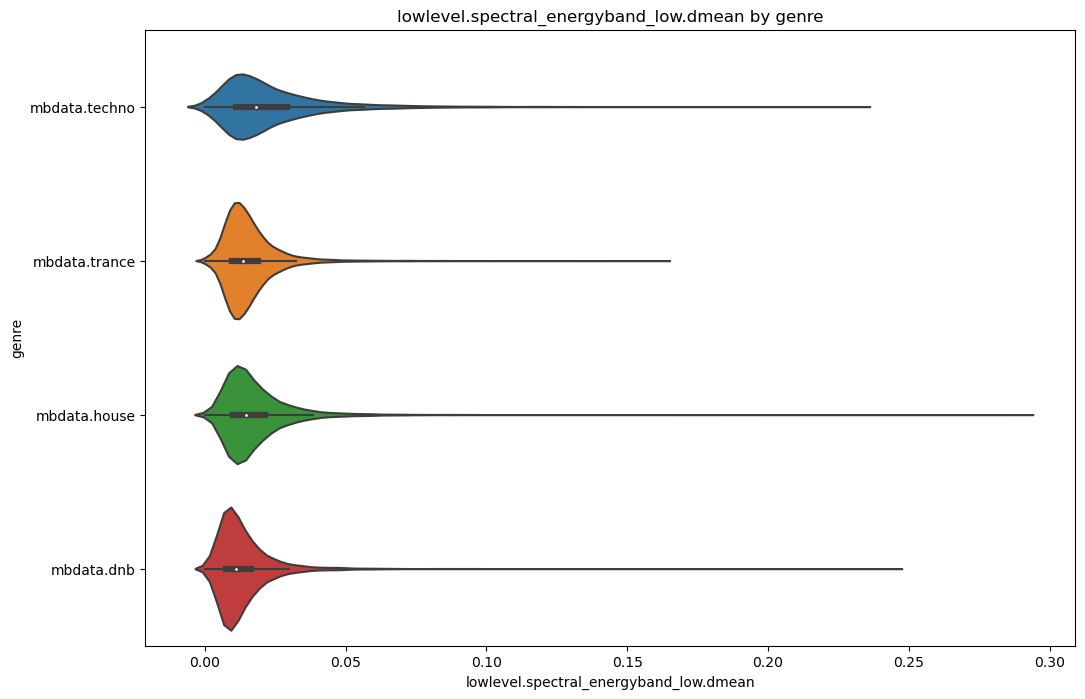

In [27]:
feature = 'lowlevel.spectral_energyband_low.dmean'

df_test = df[[feature, 'mbdata.techno', 'mbdata.trance', 'mbdata.house', 'mbdata.dnb']]
df_long = df_test.melt(id_vars=[feature], var_name='genre', value_name='Presence')
df_long = df_long[df_long['Presence'] == 1]  # Filter to keep only rows where the label is present

plt.figure(figsize=(12, 8))
sns.violinplot(x=feature, y='genre', data=df_long)
plt.title(f'{feature} by genre')
plt.show()

### Functions for EDA

In [28]:
def remove_highly_correlated_features(df, priority_list, group='all', threshold=0.9):
    '''
    Gives set of features to remove which are highly correlated, based on priority
    Args:
        df (DataFrame): Given DataFrame
        group (list): List of features to consider
        priority_list (list): List of feature suffixes (e.g. mean, median) of decreasing priorities.  Lower priority features are dropped.
        threshold (float): Threshold to indicate high correlation
    Returns:
        set: set of features to drop
    '''
    if group == 'all': group = df.columns
    # Filter out correlations that are less than the threshold
    corr_series = df[group].corr().unstack()
    high_corr = corr_series[abs(corr_series) > threshold]
    
    # Drop duplicate pairs (e.g., (A, B) and (B, A))
    high_corr = high_corr[high_corr.index.get_level_values(0) != high_corr.index.get_level_values(1)]

    # Keep track of which columns to drop based on the priority list
    to_drop = set()

    for (feature1, feature2) in high_corr.index:
        new_feature1 = re.sub(r'\.\d+(\.\d+)?$', '', feature1)
        new_feature2 = re.sub(r'\.\d+(\.\d+)?$', '', feature2)

        suffix1 = new_feature1.rsplit('.', 1)[-1]
        suffix2 = new_feature2.rsplit('.', 1)[-1]
        if suffix1 in to_drop or suffix2 in to_drop:
            continue
        
        # Determine which feature has higher priority
        if suffix1 in priority_list and suffix2 in priority_list:
            priority1 = priority_list.index(suffix1)
            priority2 = priority_list.index(suffix2)
            if priority1 < priority2:
                to_drop.add(feature2)
            else:
                to_drop.add(feature1)
        elif suffix1 in priority_list:
            to_drop.add(feature2)
        elif suffix2 in priority_list:
            to_drop.add(feature1)

    return to_drop

In [29]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [30]:
def common_prefix(strs):
    prefix = strs[0]
    for s in strs[1:]:
        while not s.startswith(prefix):
            prefix = prefix[:-1]
            if not prefix:
                return ""
            
    return prefix

In [31]:
def PCA_group(df, group='all', threshold=0.9):
    '''
    Does PCA on a DataFrame given a list of features and a given threshold for variance accountability
    Inputs:
        df (DataFrame)
        group (list of strings): list of feature names to consider
        threshold (float): percent of variance to account for
    Returns:
        DataFrame with new components and renamed columns 
    '''
    if group == 'all': 
        group = df.columns
    else:
        group = [feature for feature in group if feature in df.columns]

    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df[group])

    # doing PCA on the scaled feature group
    pca = PCA()
    pca_result = pca.fit_transform(df_scaled)

    # finding the number of components needed to explain threshold% of the variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = explained_variance.cumsum()
    n_components = next(i for i, total in enumerate(cumulative_variance) if total >= threshold) + 1

    # creating DataFrame with new components
    pca_final = PCA(n_components=n_components)
    pca_result = pca_final.fit_transform(df_scaled)
    pca_df = pd.DataFrame(pca_result)
    pca_df.columns = [f'{common_prefix(group)}PCA.{i}' for i in range(pca_df.shape[1])]

    return pca_df

### Initial Correlation Analysis on Scalar Features

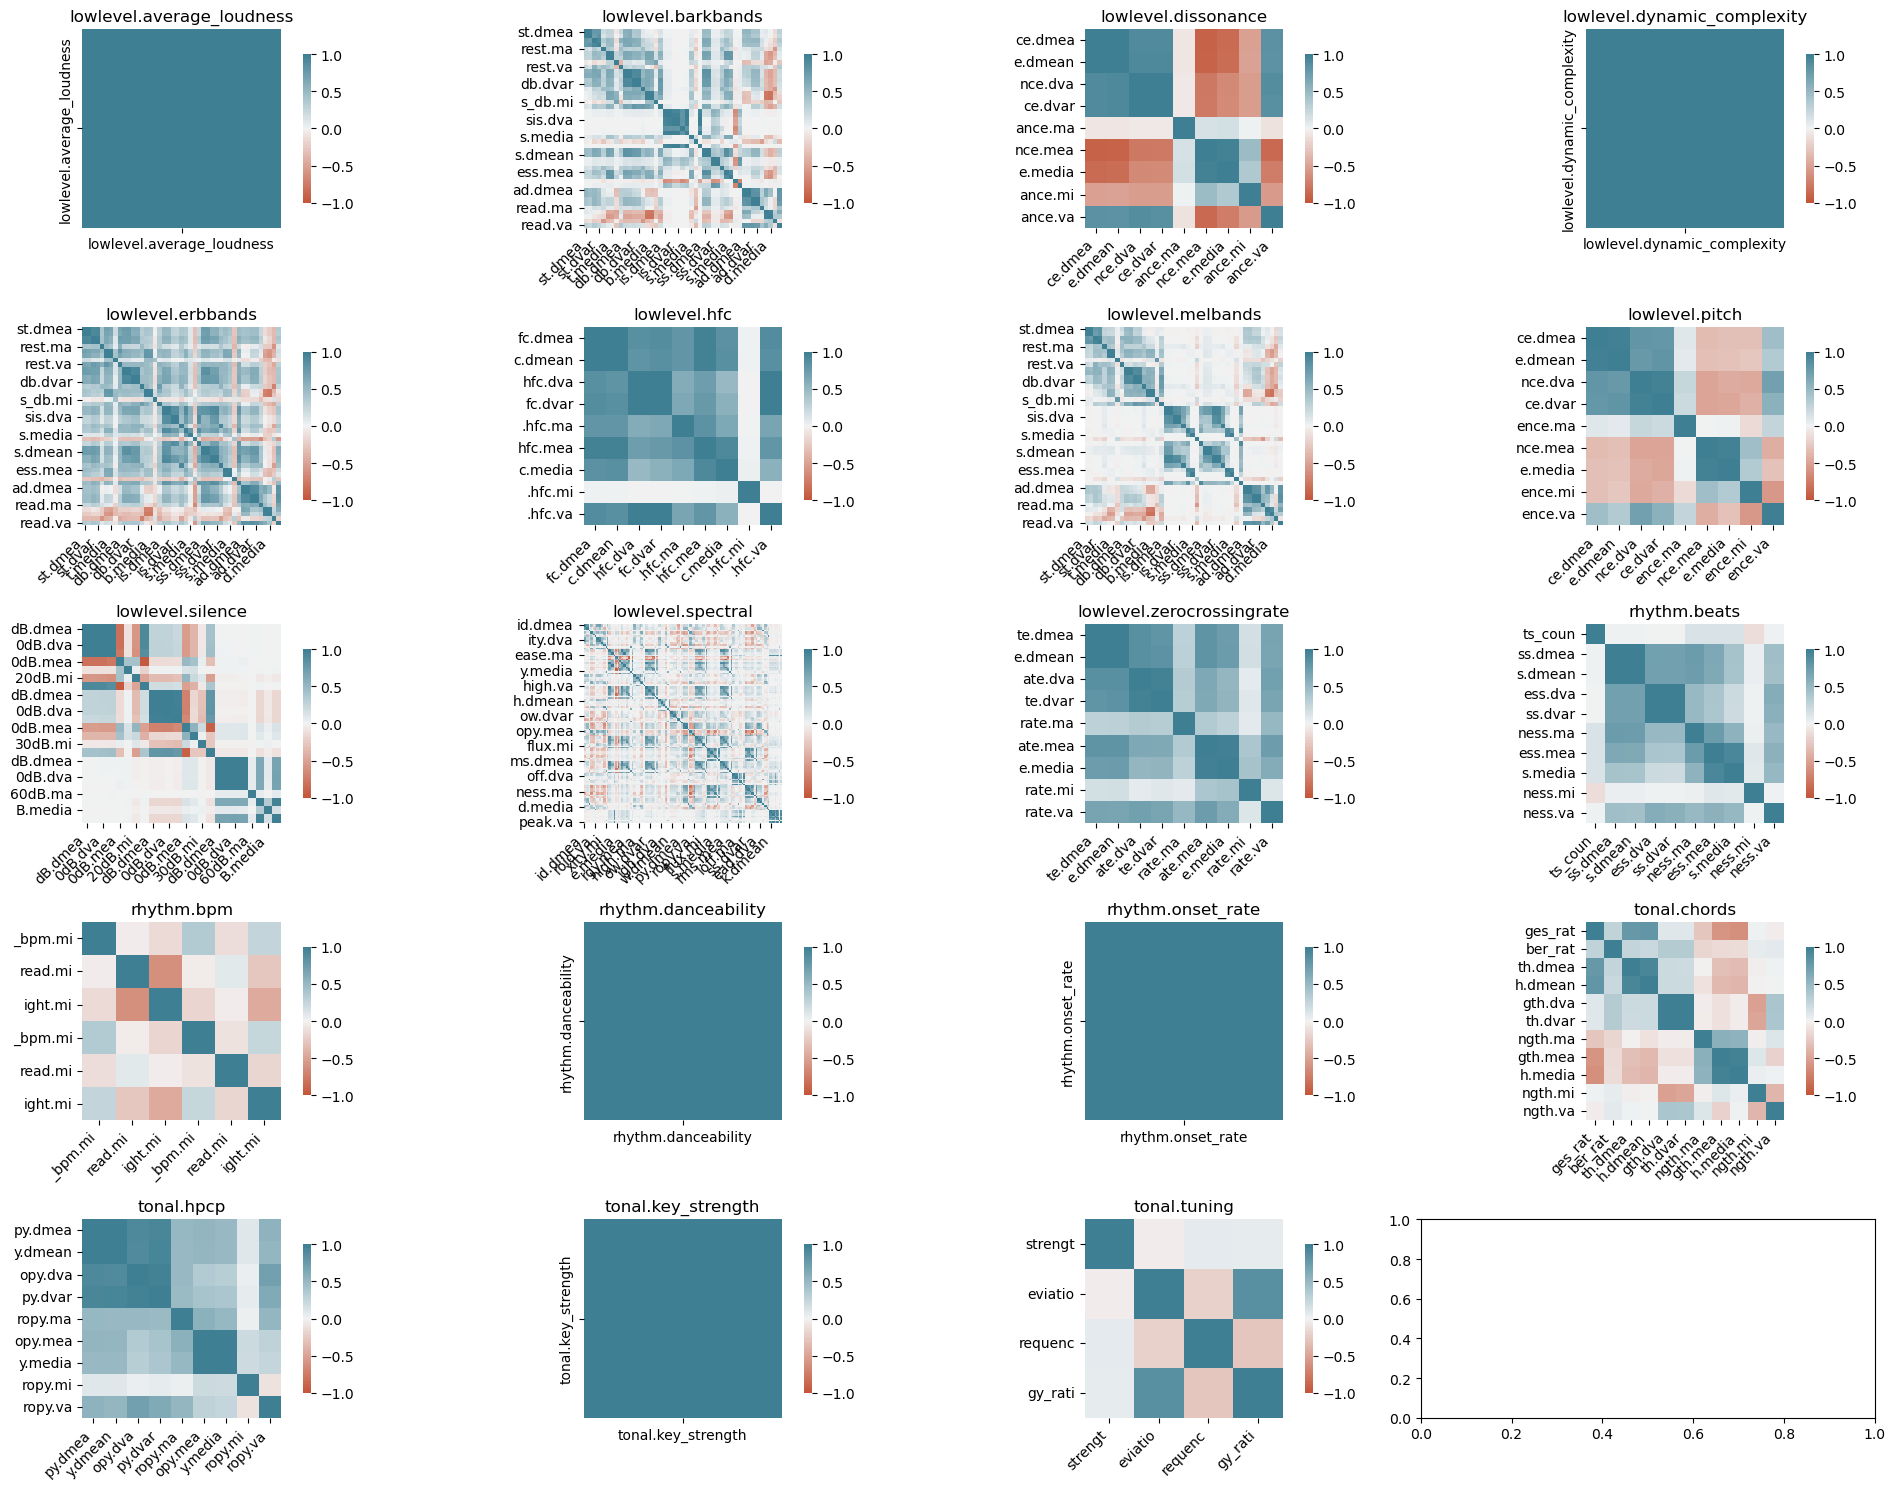

In [32]:
N = len(features_scalar_grouped) # N = 19

fig, axes = plt.subplots(5, 4, figsize=(20,15))

for i in range(5):
    for j in range(4):
        if 4*i+j == 19: continue 
        #print(features_scalar_grouped[4*i+j])
        sns.heatmap(
            numeric_df[features_scalar_grouped[4*i+j]].corr(), 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            cbar_kws={'shrink': 0.75},
            square=True,
            ax = axes[i,j]
        )

        if len(features_scalar_grouped[4*i+j]) == 1:
            axes[i,j].set_title(features_scalar_grouped[4*i+j][0])
            continue

        xticks = [label.get_text() for label in axes[i,j].get_xticklabels()]
        yticks = [label.get_text() for label in axes[i,j].get_yticklabels()]
        new_xticks = [str(label)[-8:-1] for label in xticks] #axes labels are given by the last 8 characters.  Ideally, there would be a better way to label this.
        new_yticks = [str(label)[-8:-1] for label in yticks]

        axes[i,j].set_title(re.findall(r'(^(?:lowlevel|tonal|rhythm)\.[a-zA-Z0-9]+).*', features_scalar_grouped[4*i+j][0])[0])

        axes[i,j].set_xticklabels(
            new_xticks,
            rotation=45,
            horizontalalignment='right'
        );

        axes[i,j].set_yticklabels(
            new_yticks,
            horizontalalignment='right'
        );

plt.tight_layout()
plt.show()

### EDA Version 1
We do correlation analysis on scalar features, then we do PCA on groups of vector features.
Lastly, we do another correlation analysis on all the final features.

In [34]:
# Producing a list of scalar features with highly correlated scalar features removed

priority_list = ['mean', 'var', 'max', 'min', 'median', 'dmean', 'dvar', 'dmean2', 'dvar2']
features_scalar_high_corr = remove_highly_correlated_features(numeric_df, 
                                                              group=features_scalar, 
                                                              priority_list=priority_list, 
                                                              threshold=0.9)


In [35]:
# creating a DataFrame with only scalar features with the highly correlated ones removed
scalar_df = numeric_df[features_scalar]
scalar_df = scalar_df.drop(columns=features_scalar_high_corr)

In [36]:
# creating a DataFrame with only vector features after PCA on each group
numeric_df_PCA_vector = pd.DataFrame()
for group in features_vector_grouped:
    df_pca = PCA_group(numeric_df, group)
    numeric_df_PCA_vector = pd.concat([numeric_df_PCA_vector, df_pca], axis=1)

df_v1 = pd.concat([scalar_df, numeric_df_PCA_vector], axis=1)

In [37]:
high_corr = remove_highly_correlated_features(df_v1, group='all', priority_list=priority_list, threshold=0.85)
df_v1 = df_v1.drop(columns=high_corr)
df_v1_final = pd.concat([df_v1, df[non_numeric_features]], axis=1)

In [64]:
df_v1_final.to_pickle('electronic_df_EDAv1.pkl')

### EDA Version 2
First we remove all highly correlated features with absolute correlation >= 0.9.
Then we do PCA among groups of vector features.  

In [38]:
priority_list = ['mean', 'var', 'max', 'min', 'median', 'dmean', 'dvar', 'dmean2', 'dvar2']
highly_correlated_features = remove_highly_correlated_features(numeric_df,
                                                               group='all',
                                                               priority_list=priority_list,
                                                               threshold=0.9)

In [39]:
df_v2 = numeric_df.drop(columns=highly_correlated_features)

In [40]:
numeric_df_PCA_vector_v2 = pd.DataFrame()
for group in features_vector_grouped:
    df_pca = PCA_group(df_v2, group)
    numeric_df_PCA_vector_v2 = pd.concat([numeric_df_PCA_vector_v2, df_pca], axis=1)

In [41]:
scalar_features_v2 = [feature for feature in df_v2.columns if feature in features_scalar]
df_v2_final = pd.concat([df_v2[scalar_features_v2], numeric_df_PCA_vector_v2], axis=1)

In [42]:
high_corr_features = remove_highly_correlated_features(df_v2_final,
                                                       group='all',
                                                       priority_list=priority_list,
                                                       threshold=0.85)

df_v2_final = pd.concat([df_v2_final, df[non_numeric_features]], axis=1)

In [65]:
df_v2_final.to_pickle('electronic_df_EDAv2.pkl')

### EDA Version 3
First we do a correlation analysis, then do PCA among groups, combining scalar and vector features together.

In [51]:
features_cats = ['tonal.tuning', # nontempered_energy_ratio, frequency, equal_tempered_deviation, diatonic_strength
                    'tonal.thpcp',
                    'tonal.key_strength',
                    'tonal.hpcp', # entropy
                    'tonal.chords', # strength, histogram, number_rate, changes_rate
                    'rhythm.onset_rate',
                    'rhythm.danceability',
                    'rhythm.bpm', # first_peak, second_peak
                    'rhythm.beats', # loudness, loudness_band_ratio, count
                    'lowlevel.zerocrossingrate',
                    'lowlevel.spectral', # centroid, complexity, decrease, energy, energyband_high/low/middle_high/middle_low, 
                                        # entropy, flux, kurtosis, rms, rolloff, skewness, spread, strongpeak
                                        # contrast_coeffs, contrast_valleys
                    'lowlevel.silence_rate', # 20dB, 30dB, 60dB
                    'lowlevel.pitch_salience', # I think this got completely removed
                    'lowlevel.mfcc.mean', 'lowlevel.mfcc.icov', 'lowlevel.mfcc.cov',
                    'lowlevel.melbands', # crest, flatness, kurtosis, skewness, spread
                    'lowlevel.hfc', 
                    'lowlevel.gfcc.mean', 'lowlevel.gfcc.icov', 'lowlevel.gfcc.cov',
                    'lowlevel.erbbands', # crest, flatness, kurtosis, skewness, spread
                    'lowlevel.dynamic_complexity',
                    'lowlevel.dissonance',
                    'lowlevel.barkbands', # crest, flatness, kurtosis, skewness, spread
                    'lowlevel.average_loudness',
                    ]

In [52]:
# df_v2 already has highly correlated features removed
# now we create the groups (according to features_grouped) to apply PCA to

features_grouped_v3 = [[feature for feature in df_v2.columns if feature.startswith(cat)] for cat in features_cats]

In [55]:
df_PCA_v3 = pd.DataFrame() 
for group in features_grouped_v3:
    df_pca = PCA_group(df_v2, group = group, threshold=0.9)
    df_PCA_v3 = pd.concat([df_pca, df_PCA_v3], axis=1)

In [62]:
df_v3_final = pd.concat([df_PCA_v3, df[non_numeric_features]], axis=1)

In [66]:
df_v3_final.to_pickle('electronic_df_EDAv3.pkl')

### Testing a model with df_v2

In [429]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score

In [432]:
drop_cols = ['mbdata.id', 'mbdata.title', 'mbdata.artist-name', 'mbdata.artist-id', 'mbdata.all-tags', 'mbdata.genre']
df_v2_final = df_v2_final.drop(columns=drop_cols)

In [434]:
labels = ['mbdata.techno', 'mbdata.trance', 'mbdata.house', 'mbdata.dnb']
X = df_v2_final.drop(columns=labels)
y = df_v2_final[labels]

In [437]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [438]:
# Initialize XGBoost classifier
xgb_model = XGBClassifier()

# Use OneVsRestClassifier to handle multi-label classification
model = OneVsRestClassifier(xgb_model)

# Train the model on the training data
model.fit(X_train, y_train)

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))

In [440]:
# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = (y_pred == y_test).mean().mean()  # Mean accuracy across all labels
print(f"Mean accuracy: {accuracy * 100:.2f}%")

Mean accuracy: 83.34%


In [441]:
accuracy = (y_pred == y_test).mean()
accuracy

mbdata.techno    0.796769
mbdata.trance    0.874830
mbdata.house     0.756177
mbdata.dnb       0.905919
dtype: float64

In [442]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
report = classification_report(y_test, y_pred, target_names=['techno', 'house', 'trance', 'dnb'])
print(report)

              precision    recall  f1-score   support

      techno       0.70      0.53      0.60      2147
       house       0.84      0.70      0.76      2117
      trance       0.73      0.64      0.68      2995
         dnb       0.84      0.75      0.79      1757

   micro avg       0.77      0.65      0.70      9016
   macro avg       0.78      0.66      0.71      9016
weighted avg       0.77      0.65      0.70      9016
 samples avg       0.71      0.69      0.68      9016



c:\Users\kling\anaconda3\envs\erdos_may_2024\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
